# Import modules

In [287]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
random_state=59

In [288]:
df=pd.read_pickle('data/arbres_grenoble_clean.pkl')

# Data selection

## Removing missing years

In [289]:
#I delete the row where we don't a year for the planting
df_missing_year=df.dropna(axis=0, subset=['annee_de_plantation'])
df_clean=df.copy()
df_clean.dropna(axis=0, subset=['annee_de_plantation'], inplace=True)
df_clean['annee_de_plantation'].astype(int)
df_clean.columns


Index(['sous_categorie', 'code_parent', 'adr_secteur', 'espece',
       'stade_de_developpement', 'annee_de_plantation', 'collectivite',
       'structure', 'geo_point_2d', 'longitude', 'latitude', 'genre espece'],
      dtype='object')

## Remove sectors

In [290]:
df_clean.drop(columns=['adr_secteur'], inplace=True)

## Remove code parents and sous_categorie

In [291]:
df_clean.drop(columns=['sous_categorie', 'code_parent','collectivite','structure','geo_point_2d'], inplace=True)

## Replace stage of development with value

In [292]:
dict_replace={
    'Arbre jeune':1,
    'Arbre adulte':2,
    'Arbre vieillissant':3
}
df_clean['stade_de_developpement']=df_clean['stade_de_developpement'].fillna(0)
df_clean['stade_de_developpement']=df_clean['stade_de_developpement'].replace(dict_replace)

/tmp/ipykernel_8328/1670086062.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['stade_de_developpement']=df_clean['stade_de_developpement'].replace(dict_replace)


# Train-test split

In [293]:
from sklearn.model_selection import train_test_split
X=df_clean.drop("annee_de_plantation", axis=1)
y=df_clean["annee_de_plantation"]


X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=random_state)

# Pipeline

In [294]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

#Columns to process
num_cols_1=['stade_de_developpement','longitude','latitude']
cat_cols_1=['genre espece']

num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_1 = ColumnTransformer([
    ('num', num_pipeline, num_cols_1),
    ('cat', cat_pipeline, cat_cols_1)
])

model=Pipeline([
    ('preprocessor', preprocessor_1),
    ('regressor', RandomForestRegressor(n_jobs=-1,random_state=random_state))
])

In [295]:
X['stade_de_developpement'].unique()

array([1, 2, 0, 3])

# Grid Search

In [296]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [10, 50, 100, 200],
    'regressor__max_depth': [2, 5, 8,15,20]
}

grid_search = GridSearchCV(
    model, param_grid, cv=4, scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=4,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[CV 3/4] END regressor__max_depth=2, regressor__n_estimators=10;, score=(train=-178.453, test=-178.231) total time=   0.2s
[CV 4/4] END regressor__max_depth=2, regressor__n_estimators=10;, score=(train=-179.900, test=-176.997) total time=   0.3s
[CV 1/4] END regressor__max_depth=2, regressor__n_estimators=10;, score=(train=-182.344, test=-185.506) total time=   0.3s
[CV 2/4] END regressor__max_depth=2, regressor__n_estimators=10;, score=(train=-178.105, test=-179.131) total time=   0.3s
[CV 1/4] END regressor__max_depth=2, regressor__n_estimators=50;, score=(train=-180.122, test=-183.141) total time=   0.5s
[CV 2/4] END regressor__max_depth=2, regressor__n_estimators=50;, score=(train=-178.234, test=-179.252) total time=   0.6s
[CV 3/4] END regressor__max_depth=2, regressor__n_estimators=50;, score=(train=-179.214, test=-178.898) total time=   0.6s
[CV 4/4] END regressor__max_depth=2, regressor__n_estimators=50;, score=(train=-181.433, test=-178.874) total time=   0.6s
[CV 3/4] END reg

# results

In [297]:
df_results=pd.DataFrame(grid_search.cv_results_)

In [298]:
df_results_interest=df_results[['param_regressor__max_depth','param_regressor__n_estimators','mean_test_score','std_test_score']].copy()

In [299]:
dict_rename=dict(
    param_regressor__max_depth='max_depth',
    param_regressor__n_estimators='n_estimators'
)

df_results_interest.rename(columns=dict_rename, inplace=True)


In [300]:
df_results_interest['max_depth'].fillna(0, inplace=True)

/tmp/ipykernel_8328/3760158211.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_results_interest['max_depth'].fillna(0, inplace=True)


<Axes: xlabel='max_depth', ylabel='n_estimators'>

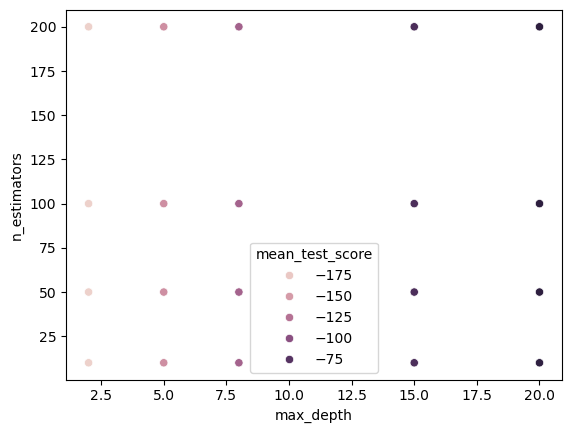

In [301]:
sns.scatterplot(
    data=df_results_interest,
    x='max_depth',
    y='n_estimators',
    hue='mean_test_score'
)

<Axes: xlabel='n_estimators', ylabel='mean_test_score'>

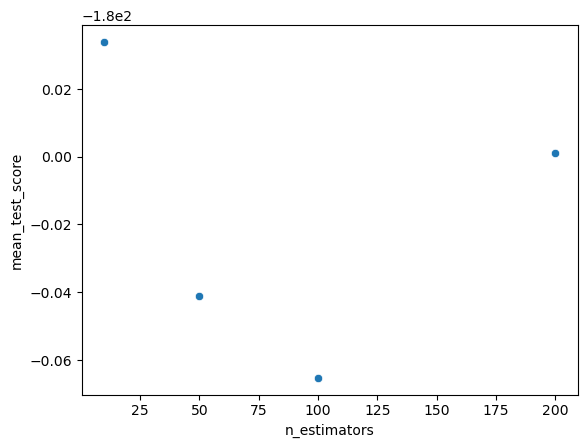

In [302]:
sns.scatterplot(
    data=df_results_interest[df_results_interest['max_depth']<5],
    x='n_estimators',
    y='mean_test_score'
)

In [303]:
model_final=grid_search.best_estimator_

In [304]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

def show_results(model, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test, graph=True):

    """
    Show two graph to compare the performance of a model
    between train data and test data
    """
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10,5), sharey=True)

    y_test_pred = model.predict(X_test)
    y_train_pred=model.predict(X_train)
    error_test=abs(y_test_pred-y_test)
    
    rmse_test=root_mean_squared_error(y_test, y_test_pred)
    rmse_train=root_mean_squared_error(y_train, y_train_pred)
    print(f"The RMSE is:")
    print(f"Test\t{round(rmse_test,1)} years")
    print(f"Train\t{round(rmse_train,1)} years")

    if graph==True:
        ax=sns.scatterplot(
            x=y_test,
            y=y_test_pred,
            hue=error_test,
            palette='gist_gray',
            ax=ax1
        )
        ax1.set_xlabel("Year of plantation")
        ax1.set_ylabel("Predicted year of plantation")
        ax1.get_legend().remove()
        ax1.set_title("Test data")

        
        error_train=abs(y_train_pred-y_train)
        ax=sns.scatterplot(
            x=y_train,
            y=y_train_pred,
            hue=error_train,
            palette='gist_gray',
            ax=ax2
        )
        ax2.set_xlabel("Year of plantation")
        ax2.set_ylabel("Predicted year of plantation")
        ax2.get_legend().remove()
        ax2.set_title("Train data")

        plt.show()

The RMSE is:
Test	7.2 years
Train	5.4 years


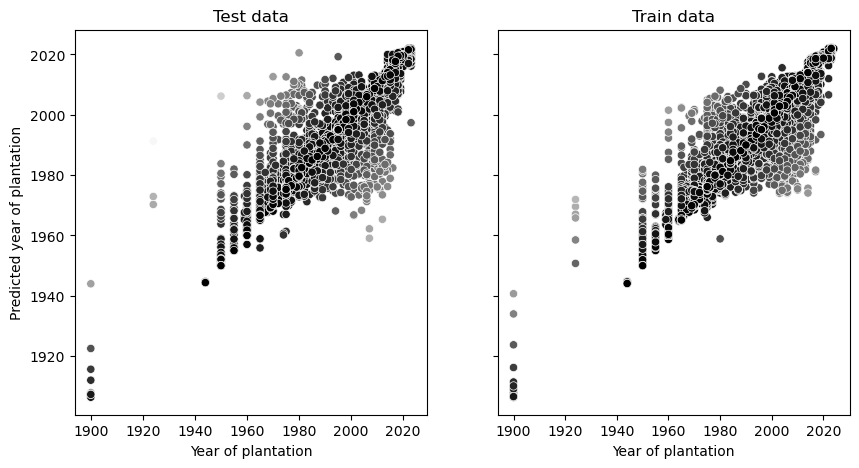

In [305]:
show_results(model_final)

In [306]:
df_heatmap=df_results_interest.pivot(index='max_depth', columns='n_estimators', values='mean_test_score')

<Axes: xlabel='n_estimators', ylabel='max_depth'>

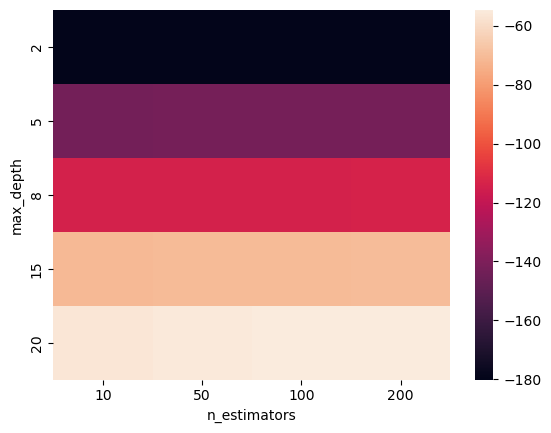

In [307]:
sns.heatmap(
    df_heatmap
    
)

# Overfitting ?

In [308]:
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.197093,0.029851,0.080548,0.028633,2,10,"{'regressor__max_depth': 2, 'regressor__n_esti...",-185.505833,-179.131033,-178.230524,-176.997056,-179.966111,3.286846,17,-182.344306,-178.104606,-178.453038,-179.899745,-179.700424,1.668266
1,0.412340,0.020339,0.137096,0.027360,2,50,"{'regressor__max_depth': 2, 'regressor__n_esti...",-183.140581,-179.252271,-178.897618,-178.873739,-180.041052,1.795781,19,-180.121573,-178.234283,-179.214170,-181.433172,-179.750800,1.178521
2,1.277700,0.192827,0.121625,0.029267,2,100,"{'regressor__max_depth': 2, 'regressor__n_esti...",-182.281741,-179.347992,-178.925392,-179.705737,-180.065216,1.309181,20,-179.324238,-178.280841,-179.238279,-182.149540,-179.748225,1.445626
3,2.002450,0.405858,0.196197,0.048555,2,200,"{'regressor__max_depth': 2, 'regressor__n_esti...",-182.237085,-179.311633,-178.831335,-179.615476,-179.998882,1.322122,18,-179.285534,-178.259329,-179.132089,-182.070474,-179.686857,1.430760
4,0.372295,0.079456,0.160390,0.027843,5,10,"{'regressor__max_depth': 5, 'regressor__n_esti...",-140.736721,-144.048742,-142.537308,-145.697902,-143.255168,1.834026,16,-140.090164,-138.498049,-140.417193,-138.665481,-139.417722,0.845988
5,1.503588,0.207706,0.150040,0.026171,5,50,"{'regressor__max_depth': 5, 'regressor__n_esti...",-140.376340,-143.130431,-141.500204,-145.315430,-142.580601,1.857931,14,-139.735850,-138.348767,-139.446273,-137.965465,-138.874089,0.736815
6,2.596913,0.365534,0.259313,0.035574,5,100,"{'regressor__max_depth': 5, 'regressor__n_esti...",-140.231520,-143.168431,-141.204061,-145.497172,-142.525296,2.015734,13,-139.630926,-138.533160,-139.427693,-138.192441,-138.946055,0.599883
7,5.542777,0.348020,0.301590,0.102212,5,200,"{'regressor__max_depth': 5, 'regressor__n_esti...",-140.217971,-143.459393,-141.302523,-145.586768,-142.641664,2.062153,15,-139.688887,-138.666918,-139.336095,-138.053660,-138.936390,0.628061
8,0.925765,0.065279,0.159580,0.016951,8,10,"{'regressor__max_depth': 8, 'regressor__n_esti...",-113.191311,-112.910029,-114.637421,-115.665254,-114.101004,1.115861,11,-107.023792,-103.184273,-108.235213,-101.829576,-105.068214,2.640652
9,2.547001,0.231296,0.121542,0.028457,8,50,"{'regressor__max_depth': 8, 'regressor__n_esti...",-112.180555,-112.473699,-115.105386,-116.971850,-114.182873,1.972307,12,-106.620938,-103.817176,-108.336636,-102.919410,-105.423540,2.166273


<Axes: xlabel='mean_test_score', ylabel='diff_test_train'>

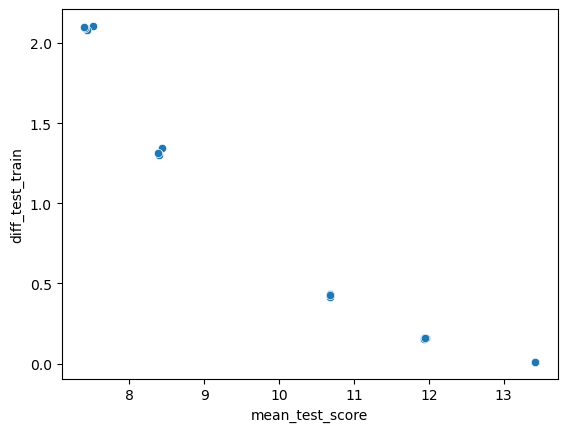

In [309]:
df_results['diff_test_train']=np.sqrt(-df_results['mean_test_score'])-np.sqrt(-df_results['mean_train_score'])
df_results['mean_test_score']=np.sqrt(-df_results['mean_test_score'])
sns.scatterplot(
    data=df_results,
    x='mean_test_score',
    y='diff_test_train'
)

<Axes: xlabel='param_regressor__n_estimators', ylabel='param_regressor__max_depth'>

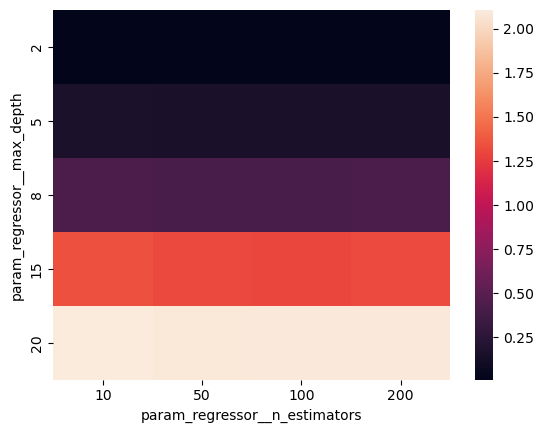

In [310]:

df_heatmap_2=df_results.pivot(
    index='param_regressor__max_depth',
    columns='param_regressor__n_estimators',
    values='diff_test_train'
)

sns.heatmap(
    data=df_heatmap_2
)

In [311]:
grid_search.best_estimator_

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
